# Team Zip-G-Force Data Filters
## Post processing for acceleration data

1. Import data analysis libraries
2. Import and store the data as “RAW DATA”
 - head_raw_df
 - neck_raw_df
 - shoulder_raw_df
 - heart_raw_df
 - com_raw_df
3. Run the data through an anti-aliasing filter (F2137 qualified)
4. Store the aliased data as “RAW DATA-ALIASED”
 - head_aaflt_df
 - neck_aaflt_df
 - shoulder_aaflt_df
 - heart_aaflt_df
 - com_aaflt_df
5. Run the aliased data through a post processing filter
 - The F2137 filter is a butterworth 4 pole
 - There are other options built currently (Chebyshev, elliptical) in matlab that will be run as well
6. Store the post processed data as “PROCESSED DATA”
 - head_pp_df
 - neck_pp_df
 - shoulder_pp_df
 - heart_pp_df
 - com_pp_df
7. Display post-processed data as a set of graphs
 - Show max and min STD


### Import Libraries

In [1]:
#Imports
import pandas as pd
import numpy as np
import glob, os

#For filtering and plotting graphs
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from scipy.signal import butter, lfilter, freqz

#Create random data with numpy
from math import pi

In [2]:
#For debugging purposes - Checkpoint
#Check is file path exists. In the following code, you will need to substitute the correspoding file path. 

os.path.exists('/Users/shellyginelle/Data/1 - Head/DATA-001.csv')

True

### Import Data
Every .CSV file records for 15 mins. The idea is to concatenate all .CSV files for each specific accelerometer positions then chop the sections into set of events: 
1. On Zip Line
 - Start
 - Arrival at Brake Mechanism
2. Offloading - Figure out the time it took for you to get back onto the Zip Line of choice

In [8]:
#Static Variables
colnames_HAM_IMU = ['Time',
            'Ax', 'Ay', 'Az', 
            'Gx', 'Gy', 'Gz', 
            'Qw', 'Qx', 'Qy', 'Qz', 
            'Mx', 'My', 'Mz', 'T'] 
colnames_HAM_IMU_ALT = ['Time',
            'Ax', 'Ay', 'Az', 
            'Gx', 'Gy', 'Gz', 
            'Qw', 'Qx', 'Qy', 'Qz', 
            'Mx', 'My', 'Mz', 'P', 'T'] 
files = glob.glob('DATA-*')

'''
1. Read all HEAD data files
'''
head_raw_dir = os.chdir("/Users/shellyginelle/Data/1 - Head/")
head_results = pd.DataFrame([], columns=colnames_HAM_IMU)

for counter, file in enumerate(files):
    head_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, engine='python')
    #Append the results into one dataframe
    head_results = head_results.append(head_df)

#Save the results into a separate combined .csv
head_results.to_csv('/Users/shellyginelle/Data/1 - Head/COMBINED_HEAD_DATA.csv')

#Read combined data, rename columns and print data
head_raw_df = pd.read_csv('/Users/shellyginelle/Data/1 - Head/COMBINED_HEAD_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

'''
2. Read all NECK C7 data files
'''
neck_raw_dir = os.chdir("/Users/shellyginelle/Data/2 - Neck C7/")
neck_results = pd.DataFrame([], columns=colnames_HAM_IMU)

for counter, file in enumerate(files):
    neck_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, engine='python')
    #Append the results into one dataframe
    neck_results = neck_results.append(neck_df)

#Save the results into a separate combined .csv
neck_results.to_csv('/Users/shellyginelle/Data/2 - Neck C7/COMBINED_NECK_DATA.csv')

#Read combined data, rename columns and print data
neck_raw_df = pd.read_csv("/Users/shellyginelle/Data/2 - Neck C7/COMBINED_NECK_DATA.csv", 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

'''
3. Read all SHOULDER data files
'''
shoulder_raw_dir = os.chdir("/Users/shellyginelle/Data/3 - Left Shoulder/")
shoulder_results = pd.DataFrame([], columns=colnames_HAM_IMU_ALT)

for counter, file in enumerate(files):
    shoulder_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7,8], sep=',', names=colnames_HAM_IMU_ALT, engine='python')
    #Append the results into one dataframe
    shoulder_results = shoulder_results.append(shoulder_df)

#Save the results into a separate combined .csv
shoulder_results.to_csv('/Users/shellyginelle/Data/3 - Left Shoulder/COMBINED_SHOULDER_DATA.csv')

#Read combined data, rename columns and print data
shoulder_raw_df = pd.read_csv("/Users/shellyginelle/Data/3 - Left Shoulder/COMBINED_SHOULDER_DATA.csv", 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU_ALT, header=None, engine='python')

'''
4. Read all HEART data files
'''
heart_raw_dir = os.chdir("/Users/shellyginelle/Data/4 - Heart/")
heart_results = pd.DataFrame([], columns=colnames_HAM_IMU)

for counter, file in enumerate(files):
    heart_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, engine='python')
    #Append the results into one dataframe
    heart_results = heart_results.append(heart_df)

#Save the results into a separate combined .csv
heart_results.to_csv('/Users/shellyginelle/Data/4 - Heart/COMBINED_HEART_DATA.csv')

#Read combined data, rename columns and print data
heart_raw_df = pd.read_csv("/Users/shellyginelle/Data/4 - Heart/COMBINED_HEART_DATA.csv", 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

'''
5. Read all COM Harness data files
'''
com_raw_dir = os.chdir("/Users/shellyginelle/Data/5 - COM Harness/")
com_results = pd.DataFrame([], columns=colnames_HAM_IMU)

for counter, file in enumerate(files):
    com_df = pd.read_csv(file, skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, engine='python')
    #Append the results into one dataframe
    com_results = com_results.append(com_df)

#Save the results into a separate combined .csv
com_results.to_csv('/Users/shellyginelle/Data/5 - COM Harness/COMBINED_COM_DATA.csv')

#Read combined data, rename columns and print data
com_raw_df = pd.read_csv("/Users/shellyginelle/Data/5 - COM Harness/COMBINED_COM_DATA.csv", 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')


#For debugging purposes - Checkpoint
#Print last dataframe to show code has completed
com_raw_df

,Time,Ax,Ay,Az,Gx,Gy,Gz,Qw,Qx,Qy,Qz,Mx,My,Mz,T
7,0.149902,291.0,2023.0,-284.0,-46.0,-1.0,-4.0,14790.556,-888.520,-6990.899,-112.965,NaN,NaN,NaN,NaN
8,0.169922,279.0,2038.0,-265.0,-35.0,4.0,-10.0,14784.786,-888.915,-7003.068,-111.325,NaN,NaN,NaN,NaN
9,0.18988,307.0,2026.0,-266.0,-27.0,8.0,11.0,14780.071,-888.890,-7013.085,-107.030,-213.0,-113.0,-276.0,NaN
10,0.2099,285.0,2047.0,-267.0,-13.0,21.0,22.0,14774.878,-888.474,-7024.150,-101.702,NaN,NaN,NaN,NaN
11,0.229919,246.0,2036.0,-273.0,-29.0,13.0,19.0,14768.650,-888.132,-7037.325,-98.408,NaN,NaN,NaN,NaN
12,0.249908,224.0,2072.0,-287.0,-47.0,11.0,4.0,14761.013,-888.733,-7053.275,-96.983,NaN,NaN,NaN,NaN
13,0.269897,237.0,2081.0,-261.0,-58.0,0.0,-2.0,14753.431,-891.293,-7068.783,-98.073,NaN,NaN,NaN,NaN
14,0.289917,250.0,2073.0,-217.0,-49.0,-24.0,-7.0,14747.981,-895.333,-7079.591,-101.331,-203.0,-120.0,-287.0,NaN
15,0.309936,254.0,2073.0,-211.0,-13.0,-18.0,-12.0,14744.114,-898.296,-7087.223,-104.260,NaN,NaN,NaN,NaN
16,0.329925,252.0,2034.0,-236.0,2.0,-20.0,-13.0,14739.788,-902.659,-7095.593,-108.850,NaN,NaN,NaN,NaN


### Manipulate Data

In [9]:
#Divide columns Ax, Ay, Az by 2048
#Divide Gx, Gy, Gz by 65.536
acceleration_cols = ['Ax', 'Ay', 'Az']
gyroscope_cols = ['Gx', 'Gy', 'Gz']
count_g = 2048
degree_sec = 65.536

for a_cols in acceleration_cols:
    head_raw_df[a_cols] = head_raw_df[a_cols].divide(count_g)
    neck_raw_df[a_cols] = neck_raw_df[a_cols].divide(count_g)
    shoulder_raw_df[a_cols] = shoulder_raw_df[a_cols].divide(count_g)
    heart_raw_df[a_cols] = heart_raw_df[a_cols].divide(count_g)
    com_raw_df[a_cols] = com_raw_df[a_cols].divide(count_g)   

for g_cols in gyroscope_cols:
    head_raw_df[g_cols] = head_raw_df[g_cols].divide(degree_sec)
    neck_raw_df[g_cols] = neck_raw_df[g_cols].divide(degree_sec)
    shoulder_raw_df[g_cols] = shoulder_raw_df[g_cols].divide(degree_sec)
    heart_raw_df[g_cols] = heart_raw_df[g_cols].divide(degree_sec)
    com_raw_df[g_cols] = com_raw_df[g_cols].divide(degree_sec)
    
#For debugging purposes - Checkpoint
#Print max to show code has completed
head_mnptd_df['Ax'].max()

In [10]:
#Save dataframe into new .csv
head_raw_df.to_csv('/Users/shellyginelle/Data/1 - Head/MANIPULATED_HEAD_DATA.csv')
head_mnptd_df = pd.read_csv('/Users/shellyginelle/Data/1 - Head/MANIPULATED_HEAD_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

neck_raw_df.to_csv('/Users/shellyginelle/Data/2 - Neck C7/MANIPULATED_NECK_DATA.csv')
neck_mnptd_df = pd.read_csv('/Users/shellyginelle/Data/2 - Neck C7/MANIPULATED_NECK_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

shoulder_raw_df.to_csv('/Users/shellyginelle/Data/3 - Left Shoulder/MANIPULATED_SHOULDER_DATA.csv')
shoulder_mnptd_df = pd.read_csv('/Users/shellyginelle/Data/3 - Left Shoulder/MANIPULATED_SHOULDER_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

heart_raw_df.to_csv('/Users/shellyginelle/Data/4 - Heart/MANIPULATED_HEART_DATA.csv')
heart_mnptd_df = pd.read_csv('/Users/shellyginelle/Data/4 - Heart/MANIPULATED_HEART_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

com_raw_df.to_csv('/Users/shellyginelle/Data/5 - COM Harness/MANIPULATED_COM_DATA.csv')
com_mnptd_df = pd.read_csv('/Users/shellyginelle/Data/5 - COM Harness/MANIPULATED_COM_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

#For debugging purposes - Checkpoint
#Print last dataframe to show code has completed
com_mnptd_df

,Time,Ax,Ay,Az,Gx,Gy,Gz,Qw,Qx,Qy,Qz,Mx,My,Mz,T
14,0.289917,0.122070,1.012207,-0.105957,-0.747681,-0.366211,-0.106812,14747.981,-895.333,-7079.591,-101.331,-203.0,-120.0,-287.0,NaN
15,0.309936,0.124023,1.012207,-0.103027,-0.198364,-0.274658,-0.183105,14744.114,-898.296,-7087.223,-104.260,NaN,NaN,NaN,NaN
16,0.329925,0.123047,0.993164,-0.115234,0.030518,-0.305176,-0.198364,14739.788,-902.659,-7095.593,-108.850,NaN,NaN,NaN,NaN
17,0.349945,0.147461,0.987793,-0.112793,-0.213623,-0.549316,-0.305176,14734.402,-910.217,-7105.691,-116.059,NaN,NaN,NaN,NaN
18,0.36993400000000004,0.137695,0.982422,-0.112305,-0.396729,-0.915527,-0.381470,14727.267,-919.704,-7119.129,-123.211,NaN,NaN,NaN,NaN
19,0.389953,0.144043,0.979980,-0.111816,-0.640869,-0.915527,-0.289917,14719.428,-929.896,-7133.899,-129.052,-215.0,-106.0,-287.0,22331.0
20,0.409973,0.129395,0.997070,-0.172852,-0.808716,-0.900269,-0.122070,14711.119,-940.544,-7149.571,-131.993,NaN,NaN,NaN,NaN
21,0.429962,0.163574,1.019531,-0.126953,-0.900269,-0.656128,0.228882,14704.343,-947.441,-7162.613,-130.583,NaN,NaN,NaN,NaN
22,0.449981,0.138184,1.028809,-0.131836,-0.640869,-0.259399,0.366211,14698.922,-950.989,-7173.361,-125.046,NaN,NaN,NaN,NaN
23,0.47003100000000003,0.145508,1.025879,-0.117676,-0.198364,0.076294,0.549316,14696.789,-953.747,-7177.503,-116.786,NaN,NaN,NaN,NaN


### Filter Data

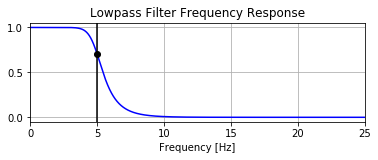

In [12]:
#Run the data through an anti-aliasing filter (F2137 qualified), save results as aliased data - aaflt
'''
head_aaflt_df
neck_aaflt_df
shoulder_aaflt_df
heart_aaflt_df
com_aaflt_df
'''
#TODO

#Run the aliased data through a post processing butterworth filter, save results as post processed data - pp
'''
head_pp_df
neck_pp_df
shoulder_pp_df
heart_pp_df
com_pp_df
'''

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs #The Nyquist frequency is half the sampling rate.
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 50.0       # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

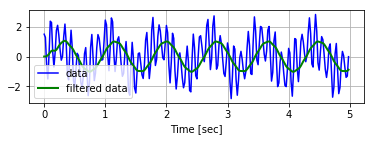

In [13]:
# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [14]:
# The data to be filtered is as follows:
'''
head_mnptd_df
neck_mnptd_df
shoulder_mnptd_df
heart_mnptd_df
com_mnptd_df
'''

cols_to_filter = ['Ax', 'Ay', 'Az', 
            'Gx', 'Gy', 'Gz', 
            'Qw', 'Qx', 'Qy', 'Qz'] 

# Filter the data, and plot both the original and filtered signals.
for cols in cols_to_filter:
    head_mnptd_df[cols] = butter_lowpass_filter(head_mnptd_df[cols], cutoff, fs, order)
    neck_mnptd_df[cols] = butter_lowpass_filter(neck_mnptd_df[cols], cutoff, fs, order)
    shoulder_mnptd_df[cols] = butter_lowpass_filter(shoulder_mnptd_df[cols], cutoff, fs, order)
    heart_mnptd_df[cols] = butter_lowpass_filter(heart_mnptd_df[cols], cutoff, fs, order)
    com_mnptd_df[cols] = butter_lowpass_filter(com_mnptd_df[cols], cutoff, fs, order)

In [15]:
#Save dataframe into new .csv
head_mnptd_df.to_csv('/Users/shellyginelle/Data/1 - Head/BUTTERWORTH_FLTR_HEAD_DATA.csv')
head_butterflt_df = pd.read_csv('/Users/shellyginelle/Data/1 - Head/BUTTERWORTH_FLTR_HEAD_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

neck_mnptd_df.to_csv('/Users/shellyginelle/Data/2 - Neck C7/BUTTERWORTH_FLTR_NECK_DATA.csv')
neck_butterflt_df = pd.read_csv('/Users/shellyginelle/Data/2 - Neck C7/BUTTERWORTH_FLTR_NECK_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

shoulder_mnptd_df.to_csv('/Users/shellyginelle/Data/3 - Left Shoulder/BUTTERWORTH_FLTR_SHOULDER_DATA.csv')
shoulder_butterflt_df = pd.read_csv('/Users/shellyginelle/Data/3 - Left Shoulder/BUTTERWORTH_FLTR_SHOULDER_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

heart_mnptd_df.to_csv('/Users/shellyginelle/Data/4 - Heart/BUTTERWORTH_FLTR_HEART_DATA.csv')
heart_butterflt_df = pd.read_csv('/Users/shellyginelle/Data/4 - Heart/BUTTERWORTH_FLTR_HEART_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

com_mnptd_df.to_csv('/Users/shellyginelle/Data/5 - COM Harness/BUTTERWORTH_FLTR_COM_DATA.csv')
com_butterflt_df = pd.read_csv('/Users/shellyginelle/Data/5 - COM Harness/BUTTERWORTH_FLTR_COM_DATA.csv', 
                 skiprows=[0,1,2,3,4,5,6,7], sep=',', names=colnames_HAM_IMU, header=None, engine='python')

#For debugging purposes - Checkpoint
#Print last dataframe to show code has completed
com_butterflt_df

,Time,Ax,Ay,Az,Gx,Gy,Gz,Qw,Qx,Qy,Qz,Mx,My,Mz,T
21,0.429962,0.091719,0.721432,-0.078252,-0.247640,-0.286642,-0.138259,10606.899406,-648.986477,-5103.015301,-77.423288,NaN,NaN,NaN,NaN
22,0.449981,0.119372,0.919781,-0.101632,-0.298375,-0.414804,-0.194688,13563.835265,-832.849622,-6531.188416,-101.334660,NaN,NaN,NaN,NaN
23,0.47003100000000003,0.141363,1.064307,-0.120752,-0.354187,-0.554687,-0.240410,15739.708407,-971.221108,-7587.742654,-121.028398,NaN,NaN,NaN,NaN
24,0.48999,0.154923,1.137888,-0.133761,-0.424151,-0.682412,-0.254604,16860.435743,-1047.347934,-8140.837096,-134.091285,-222.0,-108.0,-298.0,NaN
25,0.509979,0.159681,1.144401,-0.140298,-0.504870,-0.764363,-0.216908,16956.870455,-1062.548394,-8204.400654,-139.791460,NaN,NaN,NaN,NaN
26,0.529998,0.157330,1.104489,-0.141077,-0.573372,-0.766676,-0.115300,16315.985962,-1033.315253,-7914.766594,-138.926723,NaN,NaN,NaN,NaN
27,0.549987,0.150709,1.046084,-0.137431,-0.592403,-0.669579,0.047084,15352.382648,-983.739120,-7469.244893,-133.266959,NaN,NaN,NaN,NaN
28,0.5700069999999999,0.142821,0.994227,-0.131038,-0.527469,-0.480077,0.248493,14460.633956,-936.856323,-7055.649251,-124.905739,NaN,NaN,NaN,NaN
29,0.589996,0.136019,0.964129,-0.123923,-0.366367,-0.235407,0.451199,13903.342901,-908.135029,-6798.983347,-115.742353,-231.0,-74.0,-325.0,NaN
30,0.610016,0.131382,0.959269,-0.118545,-0.130572,0.006518,0.612953,13765.206877,-902.826415,-6739.640950,-107.173036,NaN,NaN,NaN,NaN


### Plot Data
1. Acceleration
2. G-Force
3. Quaternion

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



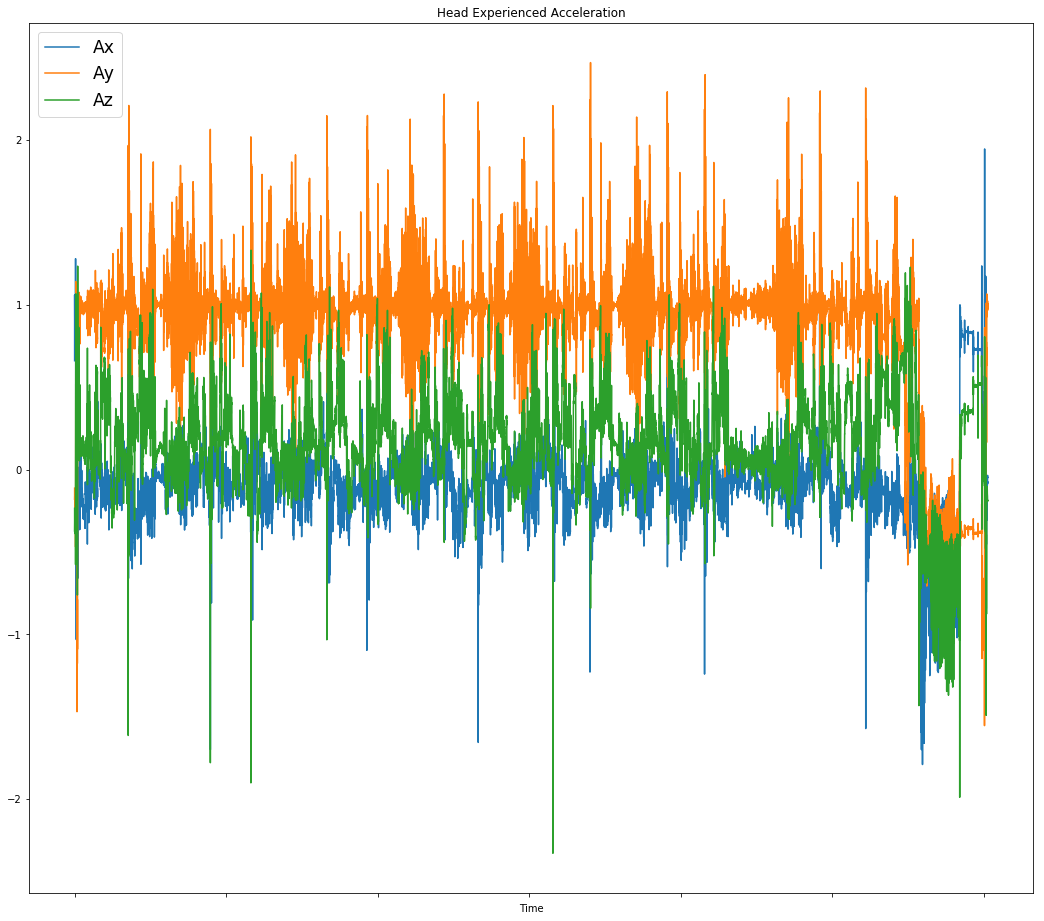

In [28]:
#For your reference, acceleration_cols = ['Ax', 'Ay', 'Az']

'''
1. Plot HEAD data
'''
head_plot = head_butterflt_df.plot(title = 'Head Experienced Acceleration',  
                                   x = 'Time', y = acceleration_cols,
                                   figsize=(18, 16), kind= 'line')
head_plot.legend(loc=2, fontsize = 'xx-large')

'''
2. Plot NECK data
'''
neck_plot = neck_butterflt_df.plot(title = 'Neck Experienced Acceleration',  
                                   x = 'Time', y = acceleration_cols,
                                   figsize=(18, 16), kind= 'line')
neck_plot.legend(loc=2, fontsize = 'xx-large')

'''
3. Plot SHOULDER data
'''
shoulder_plot = shoulder_butterflt_df.plot(title = 'Shoulder Experienced Acceleration',  
                                           x = 'Time', y = acceleration_cols,
                                           figsize=(18, 16), kind= 'line')
shoulder_plot.legend(loc=2, fontsize = 'xx-large')

'''
4. Plot HEART data
'''
heart_plot = heart_butterflt_df.plot(title = 'Heart Experienced Acceleration',  
                                     x = 'Time', y = acceleration_cols,
                                     figsize=(18, 16), kind= 'line')
heart_plot.legend(loc=2, fontsize = 'xx-large')

'''
5. Plot COM data
'''
com_plot = com_butterflt_df.plot(title = 'COM Experienced Acceleration',  
                                 x = 'Time', y = acceleration_cols,
                                figsize=(18, 16), kind= 'line')
com_plot.legend(loc=2, fontsize = 'xx-large')

In [47]:
#For debugging purposes
#Analyzing by chunks along the timeframe

#head_run1 = head_raw_df.iloc[74:91]
#head_run1_plot = head_run1.plot(title = 'Head Experienced Acceleration',  x = 'Time', y = acceleration)
#head_run1_plot.legend(loc=2, fontsize = 'xx-large')

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



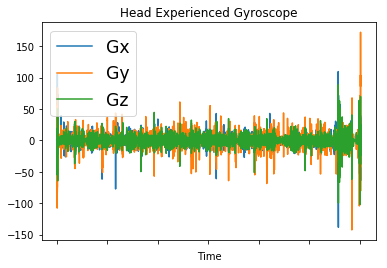

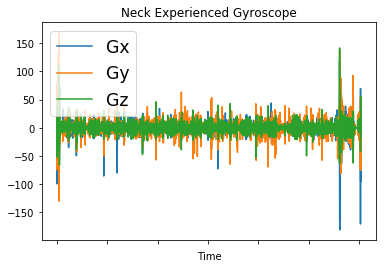

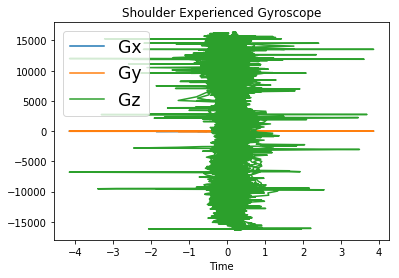

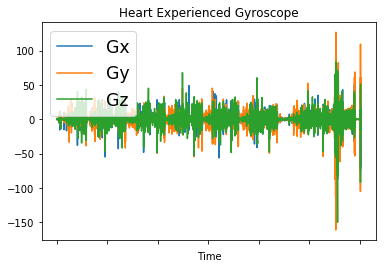

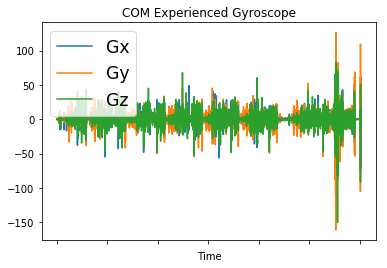

In [34]:
#For your reference, gyroscope_cols = ['Gx', 'Gy', 'Gz']

'''
1. Plot HEAD data
'''
head_plot = head_butterflt_df.plot(title = 'Head Experienced Gyroscope',  
                                   x = 'Time', y = gyroscope_cols,
                                   figsize=(18, 16), kind= 'line')
head_plot.legend(loc=2, fontsize = 'xx-large')

'''
2. Plot NECK data
'''
neck_plot = neck_butterflt_df.plot(title = 'Neck Experienced Gyroscope',  
                                   x = 'Time', y = gyroscope_cols,
                                   figsize=(18, 16), kind= 'line')
neck_plot.legend(loc=2, fontsize = 'xx-large')

'''
3. Plot SHOULDER data
'''
shoulder_plot = shoulder_butterflt_df.plot(title = 'Shoulder Experienced Gyroscope',  
                                           x = 'Time', y = gyroscope_cols,
                                           figsize=(18, 16), kind= 'line')
shoulder_plot.legend(loc=2, fontsize = 'xx-large')

'''
4. Plot HEART data
'''
heart_plot = heart_butterflt_df.plot(title = 'Heart Experienced Gyroscope',  
                                     x = 'Time', y = gyroscope_cols,
                                     figsize=(18, 16), kind= 'line')
heart_plot.legend(loc=2, fontsize = 'xx-large')

'''
5. Plot COM data
'''
com_plot = com_butterflt_df.plot(title = 'COM Experienced Gyroscope',  
                                 x = 'Time', y = gyroscope_cols,
                                 figsize=(18, 16), kind= 'line')
com_plot.legend(loc=2, fontsize = 'xx-large')

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



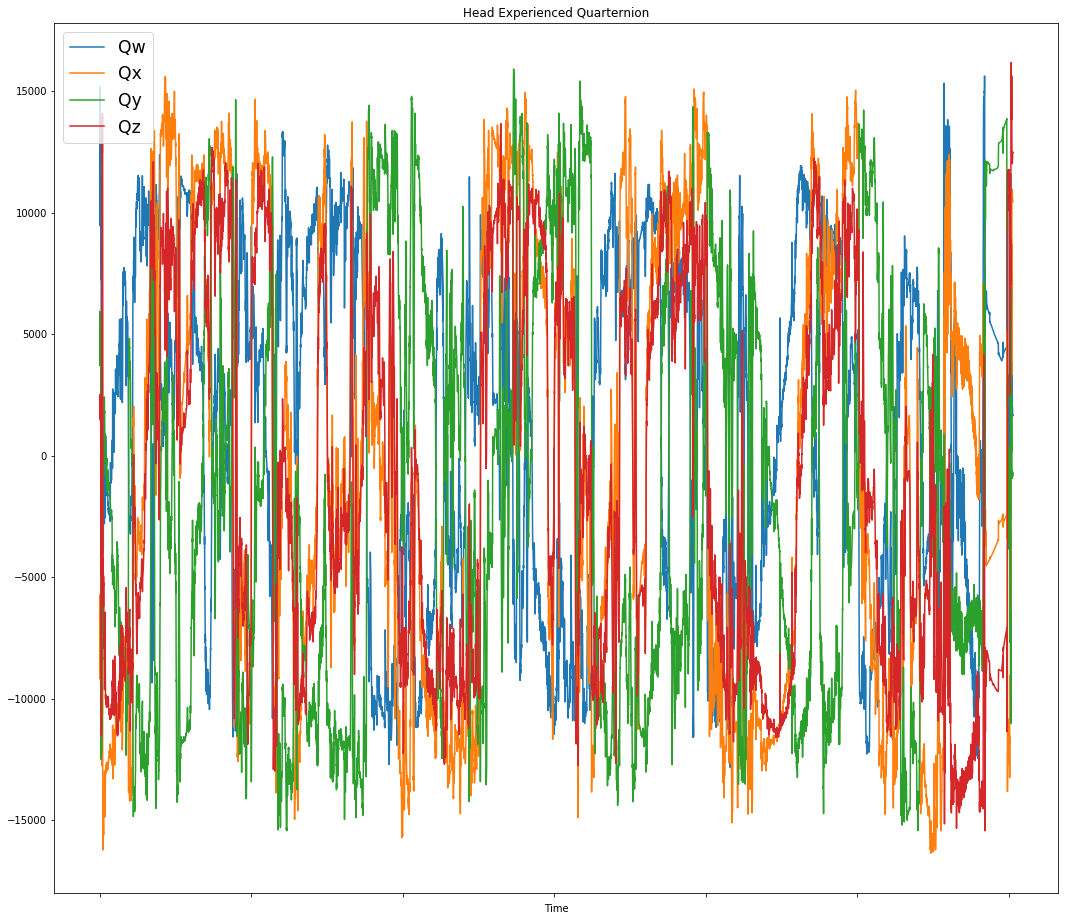

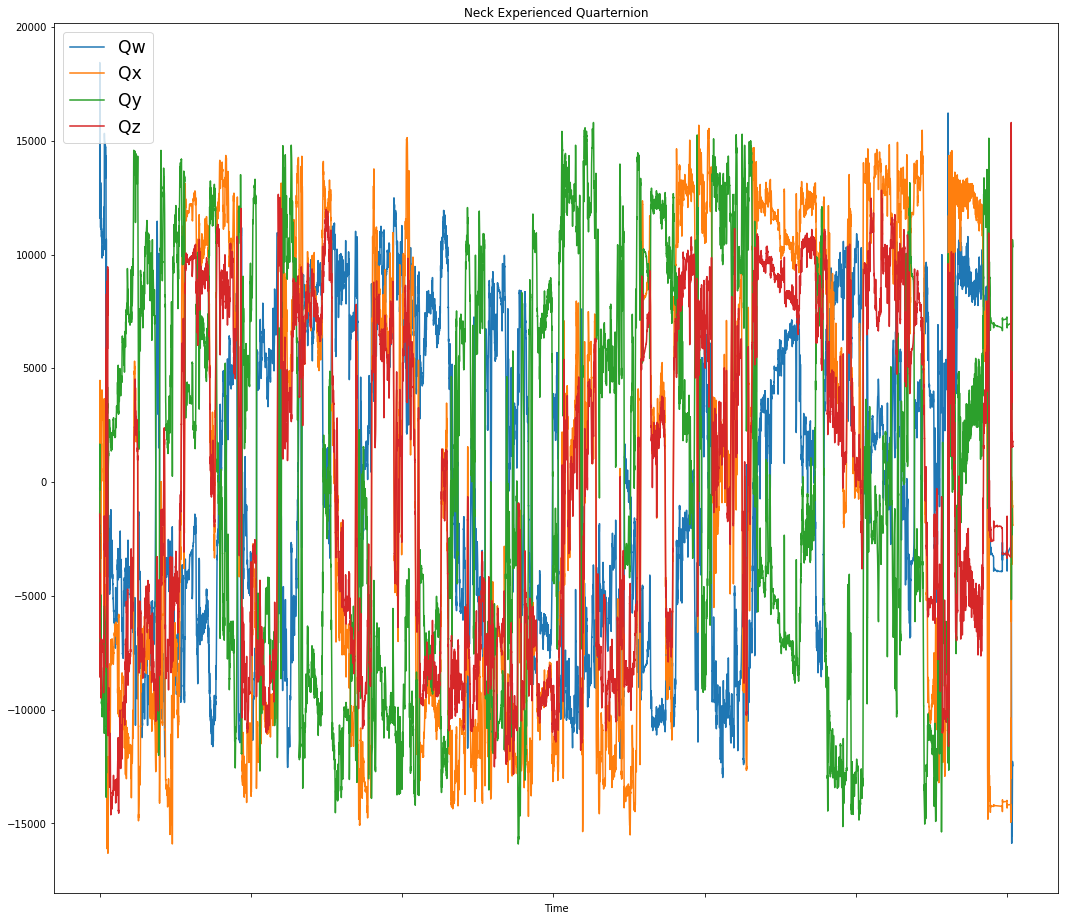

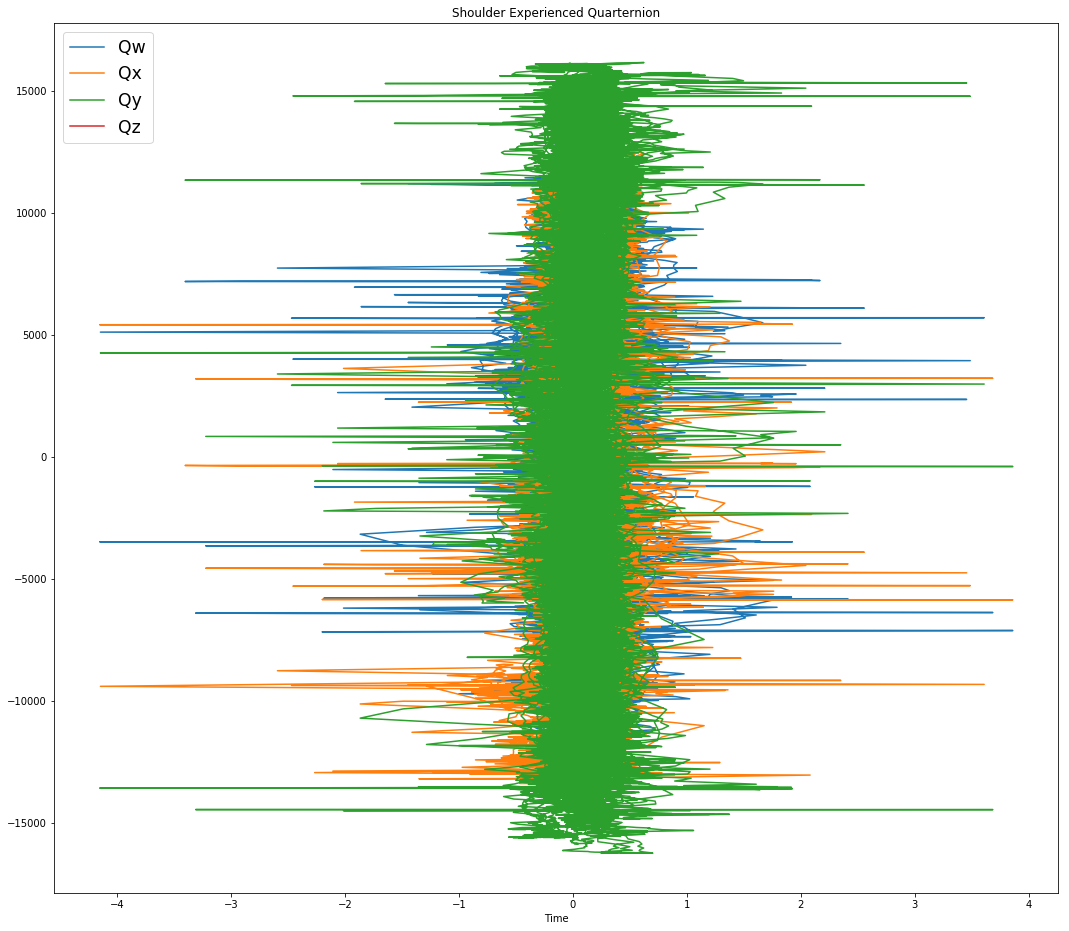

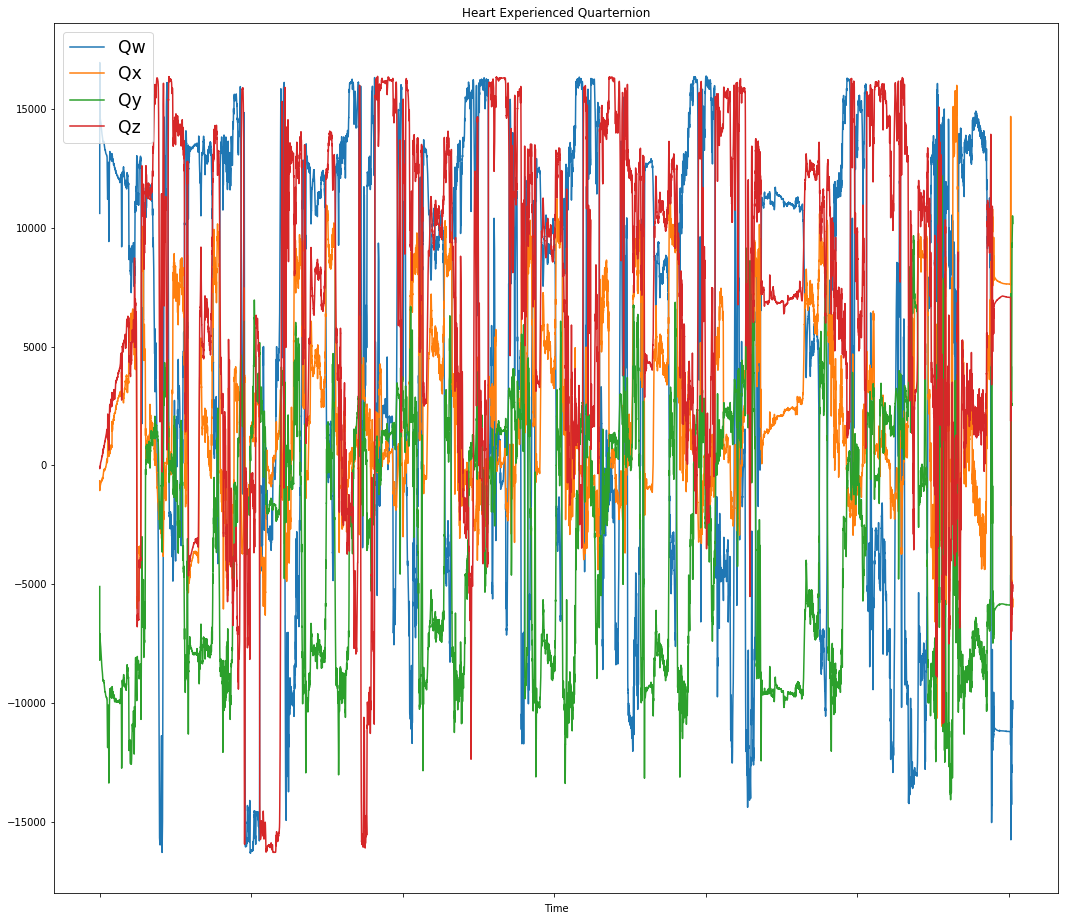

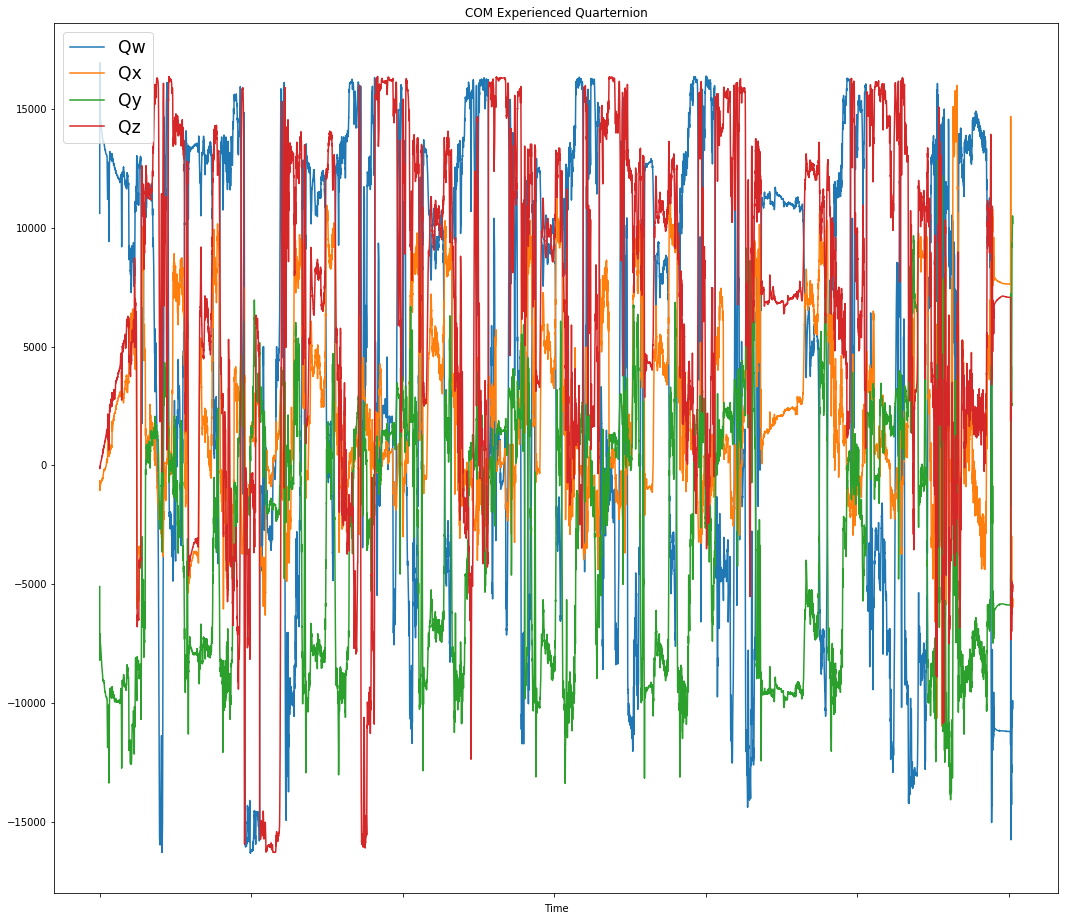

In [29]:
quarternion_cols = ['Qw', 'Qx', 'Qy', 'Qz']

'''
1. Plot HEAD data
'''
head_plot = head_butterflt_df.plot(title = 'Head Experienced Quarternion',  
                                   x = 'Time', y = quarternion_cols,
                                   figsize=(18, 16), kind= 'line')
head_plot.legend(loc=2, fontsize = 'xx-large')

'''
2. Plot NECK data
'''
neck_plot = neck_butterflt_df.plot(title = 'Neck Experienced Quarternion',  
                                   x = 'Time', y = quarternion_cols,
                                   figsize=(18, 16), kind= 'line')
neck_plot.legend(loc=2, fontsize = 'xx-large')

'''
3. Plot SHOULDER data
'''
shoulder_plot = shoulder_butterflt_df.plot(title = 'Shoulder Experienced Quarternion',  
                                           x = 'Time', y = quarternion_cols,
                                   figsize=(18, 16), kind= 'line')
shoulder_plot.legend(loc=2, fontsize = 'xx-large')

'''
4. Plot HEART data
'''
heart_plot = heart_butterflt_df.plot(title = 'Heart Experienced Quarternion',  
                                     x = 'Time', y = quarternion_cols,
                                   figsize=(18, 16), kind= 'line')
heart_plot.legend(loc=2, fontsize = 'xx-large')

'''
5. Plot COM data
'''
com_plot = com_butterflt_df.plot(title = 'COM Experienced Quarternion',  
                                 x = 'Time', y = quarternion_cols,
                                   figsize=(18, 16), kind= 'line')
com_plot.legend(loc=2, fontsize = 'xx-large')

### Data Analysis

#### Acceleration & Gyroscope
1. MAX vs MIN experienced
2. Dependent on the MAX and MIN recorded, what was the longest duration of that acceleration experienced?

#### Quarternion
1. What was the position of the test participant? This will should be mapped to the acceleration experienced.

In [ ]:
'''
head_raw_df
neck_raw_df
shoulder_raw_df
heart_raw_df
com_raw_df
'''

#Acceleration
head_ax_max = head_raw_df['Ax'].max()
head_ax_max/2048

head_ay_max = head_raw_df['Ay'].max()
head_ay_max/2048

head_az_max = head_raw_df['Az'].max()
head_az_max/2048

head_ax_min = head_raw_df['Ax'].min()
head_ax_min/2048

head_ay_min = head_raw_df['Ay'].min()
head_ay_min/2048

head_az_min = head_raw_df['Az'].min()
head_az_min/2048

#Gyroscope
head_gx_min = head_raw_df['Gx'].min()
head_gx_min/65.536

head_gx_min = head_raw_df['Gx'].max()
head_gx_min/65.536